In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.lines import Line2D

In [2]:
table = pd.read_csv("/Users/sathlerar/Desktop/23-11-20_prediction_quantification/roi_data.csv")
table.head()

,Source,RoiType,Area,Mean,Min,Max,Circ.,IntDen,Median,RawIntDen,AR,Round,Solidity
0,221114mtDNA-and-Tom20_Aged_Image8,punctate,0.712,69.378,18,122,0.872,49.404,72,11378.0,1.207,0.829,0.921
1,221114mtDNA-and-Tom20_Aged_Image8,punctate,0.061,31.143,23,43,0.993,1.893,31,436.0,1.371,0.729,0.848
2,221114mtDNA-and-Tom20_Aged_Image8,punctate,0.182,49.143,15,103,0.951,8.962,45,2064.0,1.164,0.859,0.884
3,221114mtDNA-and-Tom20_Aged_Image8,punctate,0.130,42.033,18,70,0.877,5.475,44,1261.0,1.180,0.848,0.845
4,221114mtDNA-and-Tom20_Aged_Image8,punctate,0.148,35.324,13,57,0.919,5.215,36,1201.0,1.391,0.719,0.883


In [3]:
table_edits = table
table_edits['Group'] = table['Source'].str.split("_").str[1]
table_edits['Date'] = table['Source'].str.split('m').str[0]
print(f"Table shape {table_edits.shape}")
table_edits.head()

Table shape (23691, 15)


,Source,RoiType,Area,Mean,Min,Max,Circ.,IntDen,Median,RawIntDen,AR,Round,Solidity,Group,Date
0,221114mtDNA-and-Tom20_Aged_Image8,punctate,0.712,69.378,18,122,0.872,49.404,72,11378.0,1.207,0.829,0.921,Aged,221114
1,221114mtDNA-and-Tom20_Aged_Image8,punctate,0.061,31.143,23,43,0.993,1.893,31,436.0,1.371,0.729,0.848,Aged,221114
2,221114mtDNA-and-Tom20_Aged_Image8,punctate,0.182,49.143,15,103,0.951,8.962,45,2064.0,1.164,0.859,0.884,Aged,221114
3,221114mtDNA-and-Tom20_Aged_Image8,punctate,0.130,42.033,18,70,0.877,5.475,44,1261.0,1.180,0.848,0.845,Aged,221114
4,221114mtDNA-and-Tom20_Aged_Image8,punctate,0.148,35.324,13,57,0.919,5.215,36,1201.0,1.391,0.719,0.883,Aged,221114


In [4]:
def remove_outliers_by_cell(df):
    new_dfs = []
    for source in df["Source"].unique():
        for rt in df["RoiType"].unique():
            source_df = df[(df["Source"] == source) & (df["RoiType"] == rt)]
            for metric in ["Area", "Mean", "Min", "Max", "Circ.", "IntDen", "Median", "RawIntDen", "AR", "Round", "Solidity"]:
                metric_list = source_df[metric]
                p1, p99 = np.mean(metric_list) - 3 * np.std(metric_list), np.mean(metric_list) + 3 * np.std(metric_list)
                source_df[(source_df[metric] <= p1) & (source_df[metric] >= p99)].loc[:,metric] = np.nan
            new_dfs.append(source_df)
    return pd.concat(new_dfs)

def remove_outliers_as_dataset(df):
    new = df.copy()
    for metric in ["Area", "Mean", "Min", "Max", "Circ.", "IntDen", "Median", "RawIntDen", "AR", "Round", "Solidity"]:
        metric_list = df[metric]
        p1, p99 = np.percentile(metric_list, (1, 99))
        new[metric].where(new[metric].between(p1, p99), inplace=True)
        # new[(new[metric] <= p1) & (new[metric] >= p99)].loc[:,metric] = np.nan
    return new


In [5]:
# no_outlier = remove_outliers_by_cell(table_edits)
no_outlier = remove_outliers_as_dataset(table_edits)
# no_outlier = table_edits[table_edits["Area"] <= 50]
# no_outlier = table_edits
no_outlier.isna().sum()

Source         0
RoiType        0
Area         389
Mean         474
Min          196
Max          230
Circ.        235
IntDen       474
Median       443
RawIntDen    474
AR           469
Round        474
Solidity     454
Group          0
Date           0
dtype: int64

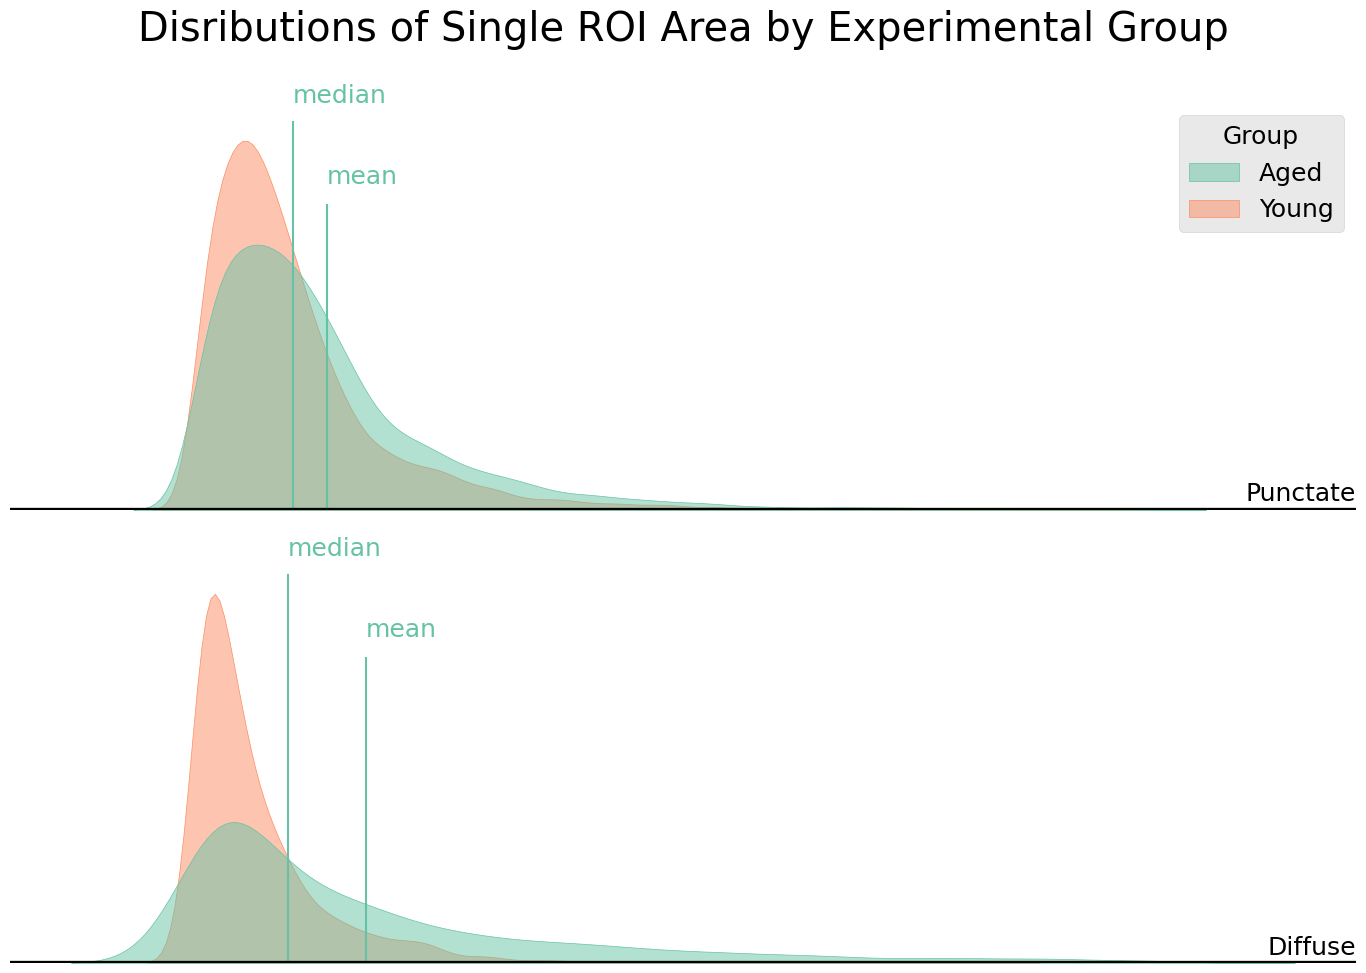

In [11]:
plt.style.use("ggplot")
plt.rcParams['axes.facecolor']='#e4e4e4'
pal = sns.color_palette(palette='Set2', n_colors=2)
fig = plt.figure(figsize=(14,10))
plt.rcParams.update({'font.size': 24})
fig.suptitle("Disributions of Single ROI Area by Experimental Group")
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

punctate=no_outlier[no_outlier["RoiType"] == 'punctate']
diffuse=no_outlier[no_outlier["RoiType"] == 'diffuse']

plt.rcParams.update({'font.size': 18})
sns.kdeplot(data=diffuse, x="Area", hue="Group", bw_adjust=1, clip_on=False, fill=True, common_norm=False, alpha=0.5, palette=pal, ax=ax2, legend=False)
dA = diffuse[diffuse["Group"] == "Aged"]
average, median = dA["Area"].mean(), dA["Area"].median()
ax2.plot([median, median], [0, ax2.get_ylim()[1]], color = pal[0])
ax2.plot([average, average], [0, ax2.get_ylim()[1] * 0.75], color = pal[0])
ax2.text(x=median, y=ax2.get_ylim()[1], s="median", color=pal[0])
ax2.text(x=average, y=ax2.get_ylim()[1]*0.8, s="mean", color=pal[0])
ax2.axhline(y=0, color='k', linewidth=3)
ax2.axhline(y=0, color='k', linewidth=3)
ax2.text(x=ax2.get_xlim()[1], y=0.2, s="Diffuse",  ha='right', color='k', va='bottom')
ax2.axis('off')

sns.kdeplot(data=punctate, x="Area", hue="Group", bw_adjust=1, clip_on=False, fill=True, common_norm=False, alpha=0.5, palette=pal, ax=ax1)
pA = punctate[punctate["Group"] == "Aged"]
average, median = pA["Area"].mean(), pA["Area"].median()
ax1.plot([median, median], [0, ax1.get_ylim()[1]], color = pal[0])
ax1.plot([average, average], [0, ax1.get_ylim()[1] * 0.75], color = pal[0])
ax1.text(x=median, y=ax1.get_ylim()[1], s="median", color=pal[0])
ax1.text(x=average, y=ax1.get_ylim()[1]*0.8, s="mean", color=pal[0])
ax1.set_xlim(ax2.get_xlim())
ax1.axhline(y=0, color='k', linewidth=3)
ax1.axhline(y=0, color='k', linewidth=3)
ax1.text(x=ax2.get_xlim()[1], y=0.2, s="Punctate",  ha='right', color='k', va='bottom')
ax1.axis('off')


fig
plt.tight_layout()